# Load datasets

In [1]:
import os

def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_name = image_file.split('.')[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip() # only read first caption
        if image_name not in captions:
                captions[image_name] = caption
    return captions

In [2]:
captions_folder = "./cvpr2016_flowers/captions"
image_folder = "./cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)

# Caption Encoding

In [3]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            'embed': torch.tensor(bert_model.encode(caption)),
            'text': caption
        }
    return encoded_captions

c:\Users\Admin\miniconda3\envs\tf-gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
encoded_captions = encode_captions(captions)

# Preprocessing

In [5]:
from PIL import Image
from torch.utils.data import Dataset

class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load captions
        self.captions = captions

        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        encoded_caption = self.captions[img_name]['embed']
        caption = self.captions[img_name]['text']

        return {
            'image': image,
            'embed_caption': encoded_caption,
            'text': caption
        }

In [6]:
import torchvision.transforms as transforms

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="./cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)

In [7]:
import matplotlib.pyplot as plt

def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [8]:
next(iter(ds))['embed_caption'].shape

torch.Size([768])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


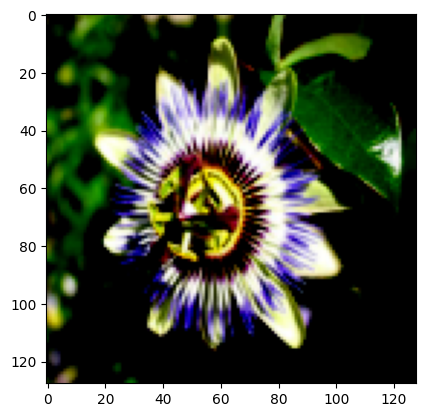

In [9]:
show_grid(next(iter(ds))['image'])

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 624
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

# Model

## Generator

In [11]:
import torch.nn as nn

class Generator(nn.Module):

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size #embedding_size = 768 -->256
        self.textEncoder = nn.Sequential(
            nn.Linear(embedding_size, reduced_dim_size),
            nn.BatchNorm1d(reduced_dim_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.upsamplingBlock = nn.Sequential(
            # 256 + 100 --> 1024
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 1024 --> 512
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(inplace=True),
            # 512 --> 256
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(inplace=True),
            # 256 --> 128
            nn.ConvTranspose2d(feature_size * 2, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(inplace=True),
            # 128 --> 128
            nn.ConvTranspose2d(feature_size, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(inplace=True),
            # 128 --> 3
            nn.ConvTranspose2d(feature_size, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings)
        input = torch.cat((noise, encoded_text), dim=1).unsqueeze(2).unsqueeze(2)
        output = self.upsamplingBlock(input)
        return output    

## Discriminator

In [12]:
class Discriminator(nn.Module):

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size
        self.imageEncoder = nn.Sequential(
            # 3 --> 128
            nn.Conv2d(num_channels, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 --> 128
            nn.Conv2d(feature_size, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 --> 256
            nn.Conv2d(feature_size, feature_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 --> 512
            nn.Conv2d(feature_size * 2, feature_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 --> 1024
            nn.Conv2d(feature_size * 4, feature_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.textEncoder = nn.Sequential(
            nn.Linear(embedding_size, reduced_dim_size),
            nn.BatchNorm1d(reduced_dim_size),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.finalBlock = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
        )
    def forward(self, input_img, text_embeddings):
        image_encoded = self.imageEncoder(input_img)
        text_encoded = self.textEncoder(text_embeddings)
        replicated_text = text_encoded.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        concat_input = torch.cat([image_encoded, replicated_text], dim=1)
        x = self.finalBlock(concat_input)
        return x.view(-1, 1)

# Training

In [13]:
import torchvision

plt_o_text_embeddings = ds[0]['embed_caption'].unsqueeze(0)
fixed_noise = torch.randn(size=(1, 100))

def plot_output(generator):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [14]:
discriminator = Discriminator(3, 128, 768, 256).to(device)
generator = Generator(100, 128, 3, 768, 256).to(device)
bce_loss = nn.BCEWithLogitsLoss()

import torch.optim as optim

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Epoch [1/500] loss_D: 2.8740 loss_G: 9.6355 time: 32.32
Epoch [2/500] loss_D: 1.6368 loss_G: 4.6850 time: 42.91
Epoch [3/500] loss_D: 1.2191 loss_G: 4.2200 time: 42.11
Epoch [4/500] loss_D: 1.2031 loss_G: 3.7888 time: 42.42
Epoch [5/500] loss_D: 0.8664 loss_G: 3.7704 time: 42.75
Epoch [6/500] loss_D: 0.9168 loss_G: 2.8724 time: 40.44
Epoch [7/500] loss_D: 1.5135 loss_G: 4.3692 time: 26.24
Epoch [8/500] loss_D: 0.9248 loss_G: 2.0665 time: 26.32
Epoch [9/500] loss_D: 0.9884 loss_G: 2.9689 time: 27.66
Epoch [10/500] loss_D: 1.0350 loss_G: 2.2234 time: 29.49
Epoch [11/500] loss_D: 0.8840 loss_G: 2.9395 time: 28.89
Epoch [12/500] loss_D: 1.2150 loss_G: 2.6998 time: 27.37
Epoch [13/500] loss_D: 1.1614 loss_G: 2.6776 time: 26.79
Epoch [14/500] loss_D: 1.1968 loss_G: 2.3866 time: 26.22
Epoch [15/500] loss_D: 0.9669 loss_G: 2.2500 time: 26.31
Epoch [16/500] loss_D: 0.9977 loss_G: 2.3331 time: 26.84
Epoch [17/500] loss_D: 1.1007 loss_G: 2.4117 time: 36.66
Epoch [18/500] loss_D: 1.0006 loss_G: 2.

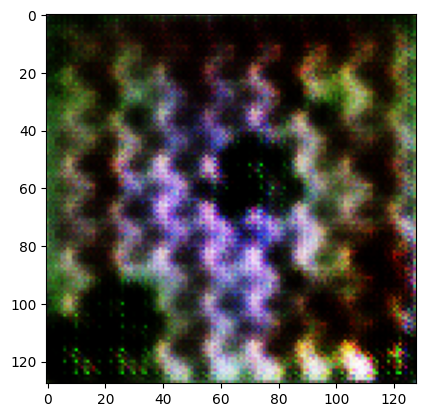

Epoch [50/500] loss_D: 1.1879 loss_G: 2.1973 time: 33.00
Epoch [51/500] loss_D: 0.9900 loss_G: 2.2770 time: 26.58
Epoch [52/500] loss_D: 1.0210 loss_G: 2.1139 time: 26.31
Epoch [53/500] loss_D: 1.0164 loss_G: 2.5722 time: 26.37
Epoch [54/500] loss_D: 1.0646 loss_G: 2.0524 time: 26.36
Epoch [55/500] loss_D: 1.1009 loss_G: 2.1753 time: 26.46
Epoch [56/500] loss_D: 1.0003 loss_G: 1.8946 time: 26.33
Epoch [57/500] loss_D: 1.0262 loss_G: 2.3075 time: 26.41
Epoch [58/500] loss_D: 1.0168 loss_G: 2.6198 time: 26.43
Epoch [59/500] loss_D: 1.0348 loss_G: 2.4098 time: 26.27
Epoch [60/500] loss_D: 1.1290 loss_G: 2.3410 time: 26.93
Epoch [61/500] loss_D: 1.0793 loss_G: 2.1697 time: 26.40
Epoch [62/500] loss_D: 0.9850 loss_G: 2.3937 time: 26.39
Epoch [63/500] loss_D: 0.9967 loss_G: 2.6303 time: 26.37
Epoch [64/500] loss_D: 1.0842 loss_G: 2.1780 time: 26.56
Epoch [65/500] loss_D: 0.9689 loss_G: 2.2838 time: 26.37
Epoch [66/500] loss_D: 1.0743 loss_G: 2.5259 time: 26.44
Epoch [67/500] loss_D: 1.1033 l

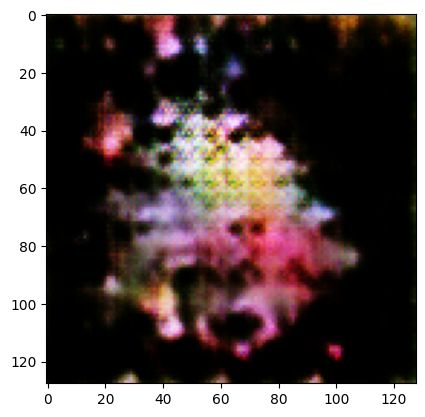

Epoch [100/500] loss_D: 0.9467 loss_G: 2.3754 time: 26.43
Epoch [101/500] loss_D: 1.0828 loss_G: 1.9102 time: 27.00
Epoch [102/500] loss_D: 0.9209 loss_G: 2.0832 time: 27.61
Epoch [103/500] loss_D: 1.2193 loss_G: 2.2174 time: 26.95
Epoch [104/500] loss_D: 0.9872 loss_G: 2.3292 time: 26.60
Epoch [105/500] loss_D: 1.0324 loss_G: 2.3499 time: 29.58
Epoch [106/500] loss_D: 1.1658 loss_G: 2.2052 time: 26.48
Epoch [107/500] loss_D: 0.9194 loss_G: 2.6393 time: 26.41
Epoch [108/500] loss_D: 1.1604 loss_G: 2.0355 time: 26.62
Epoch [109/500] loss_D: 1.0338 loss_G: 1.9935 time: 26.47
Epoch [110/500] loss_D: 0.9693 loss_G: 2.3508 time: 26.68
Epoch [111/500] loss_D: 0.8914 loss_G: 2.7302 time: 26.41
Epoch [112/500] loss_D: 1.0218 loss_G: 2.5643 time: 26.45
Epoch [113/500] loss_D: 0.8646 loss_G: 2.1337 time: 26.50
Epoch [114/500] loss_D: 1.0709 loss_G: 2.5438 time: 26.52
Epoch [115/500] loss_D: 1.1486 loss_G: 2.4602 time: 29.03
Epoch [116/500] loss_D: 0.9016 loss_G: 2.4459 time: 26.48
Epoch [117/500

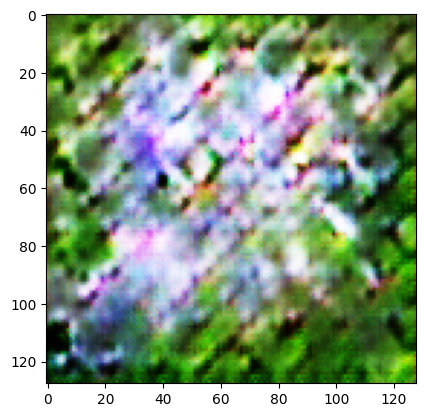

Epoch [150/500] loss_D: 0.8451 loss_G: 3.2152 time: 26.58
Epoch [151/500] loss_D: 0.9068 loss_G: 2.7157 time: 30.24
Epoch [152/500] loss_D: 1.0956 loss_G: 2.8775 time: 30.24
Epoch [153/500] loss_D: 0.7890 loss_G: 2.6592 time: 26.41
Epoch [154/500] loss_D: 0.9293 loss_G: 3.0683 time: 26.35
Epoch [155/500] loss_D: 0.7913 loss_G: 3.3616 time: 26.38
Epoch [156/500] loss_D: 0.8394 loss_G: 2.6398 time: 26.31
Epoch [157/500] loss_D: 0.8973 loss_G: 2.9977 time: 26.38
Epoch [158/500] loss_D: 0.8627 loss_G: 2.2393 time: 26.46
Epoch [159/500] loss_D: 0.9566 loss_G: 2.6082 time: 26.46
Epoch [160/500] loss_D: 0.9766 loss_G: 2.7008 time: 26.40
Epoch [161/500] loss_D: 0.8227 loss_G: 3.0690 time: 26.45
Epoch [162/500] loss_D: 0.9629 loss_G: 3.3075 time: 38.00
Epoch [163/500] loss_D: 0.8829 loss_G: 2.7407 time: 42.99
Epoch [164/500] loss_D: 0.9001 loss_G: 2.5807 time: 43.05
Epoch [165/500] loss_D: 0.8642 loss_G: 2.6556 time: 36.54
Epoch [166/500] loss_D: 0.8208 loss_G: 2.7722 time: 32.80
Epoch [167/500

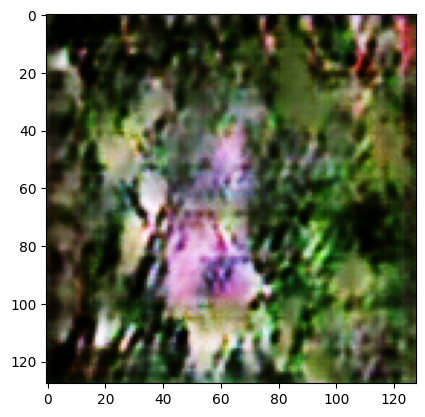

Epoch [200/500] loss_D: 0.9655 loss_G: 3.0792 time: 26.42
Epoch [201/500] loss_D: 0.4805 loss_G: 2.6377 time: 26.44
Epoch [202/500] loss_D: 0.7851 loss_G: 2.7034 time: 26.85
Epoch [203/500] loss_D: 0.6897 loss_G: 3.0107 time: 29.88
Epoch [204/500] loss_D: 0.6441 loss_G: 2.7086 time: 26.24
Epoch [205/500] loss_D: 0.7316 loss_G: 3.0228 time: 26.28
Epoch [206/500] loss_D: 0.7012 loss_G: 2.9126 time: 26.54
Epoch [207/500] loss_D: 0.9075 loss_G: 3.3787 time: 26.30
Epoch [208/500] loss_D: 0.6841 loss_G: 3.2180 time: 40.24
Epoch [209/500] loss_D: 0.5634 loss_G: 3.0597 time: 31.85
Epoch [210/500] loss_D: 0.7792 loss_G: 3.3855 time: 27.57
Epoch [211/500] loss_D: 0.6730 loss_G: 3.1494 time: 26.32
Epoch [212/500] loss_D: 0.7427 loss_G: 3.4509 time: 26.45
Epoch [213/500] loss_D: 0.8148 loss_G: 3.0347 time: 26.59
Epoch [214/500] loss_D: 0.8042 loss_G: 3.2470 time: 26.52
Epoch [215/500] loss_D: 0.8494 loss_G: 2.9999 time: 26.38
Epoch [216/500] loss_D: 0.6760 loss_G: 2.7471 time: 26.45
Epoch [217/500

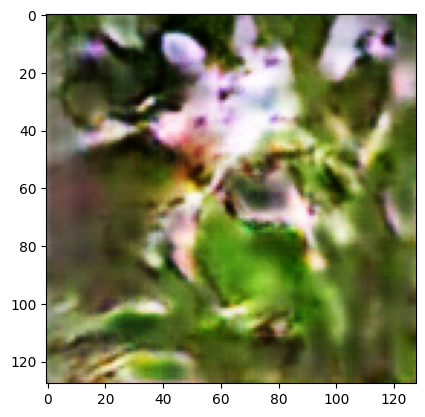

Epoch [250/500] loss_D: 0.9534 loss_G: 3.3403 time: 26.36
Epoch [251/500] loss_D: 0.6076 loss_G: 2.9942 time: 26.09
Epoch [252/500] loss_D: 0.7414 loss_G: 3.0394 time: 26.15
Epoch [253/500] loss_D: 0.4602 loss_G: 2.5819 time: 26.01
Epoch [254/500] loss_D: 0.3768 loss_G: 2.3716 time: 26.12
Epoch [255/500] loss_D: 0.9344 loss_G: 2.4097 time: 26.02
Epoch [256/500] loss_D: 0.5088 loss_G: 2.1906 time: 26.09
Epoch [257/500] loss_D: 0.6396 loss_G: 2.6369 time: 26.35
Epoch [258/500] loss_D: 0.6596 loss_G: 2.4968 time: 26.06
Epoch [259/500] loss_D: 0.4722 loss_G: 2.4708 time: 26.21
Epoch [260/500] loss_D: 0.4634 loss_G: 1.9408 time: 26.10
Epoch [261/500] loss_D: 0.4641 loss_G: 2.5228 time: 26.18
Epoch [262/500] loss_D: 0.5613 loss_G: 2.7258 time: 26.26
Epoch [263/500] loss_D: 0.5999 loss_G: 2.5145 time: 26.05
Epoch [264/500] loss_D: 0.5677 loss_G: 3.0399 time: 26.11
Epoch [265/500] loss_D: 0.8223 loss_G: 3.6955 time: 26.07
Epoch [266/500] loss_D: 0.4518 loss_G: 3.1804 time: 26.36
Epoch [267/500

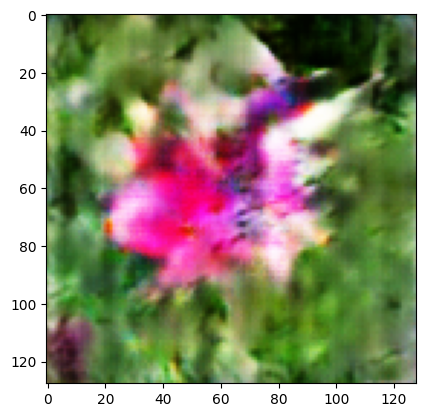

Epoch [300/500] loss_D: 1.2288 loss_G: 4.0908 time: 26.08
Epoch [301/500] loss_D: 0.4718 loss_G: 3.5976 time: 26.46
Epoch [302/500] loss_D: 0.5988 loss_G: 3.4735 time: 26.16
Epoch [303/500] loss_D: 0.5470 loss_G: 3.4310 time: 26.22
Epoch [304/500] loss_D: 0.3324 loss_G: 2.9373 time: 26.29
Epoch [305/500] loss_D: 0.5196 loss_G: 3.2722 time: 26.04
Epoch [306/500] loss_D: 0.5255 loss_G: 3.6168 time: 26.38
Epoch [307/500] loss_D: 0.6029 loss_G: 4.5101 time: 26.94
Epoch [308/500] loss_D: 0.4273 loss_G: 3.3960 time: 36.52
Epoch [309/500] loss_D: 0.6869 loss_G: 4.0892 time: 43.43
Epoch [310/500] loss_D: 0.5704 loss_G: 3.5005 time: 31.85
Epoch [311/500] loss_D: 0.7562 loss_G: 3.8850 time: 29.01
Epoch [312/500] loss_D: 0.9075 loss_G: 3.7380 time: 29.58
Epoch [313/500] loss_D: 0.4729 loss_G: 2.6096 time: 29.70
Epoch [314/500] loss_D: 0.5404 loss_G: 3.2201 time: 28.61
Epoch [315/500] loss_D: 0.7313 loss_G: 3.5526 time: 28.82
Epoch [316/500] loss_D: 0.6867 loss_G: 3.6191 time: 28.72
Epoch [317/500

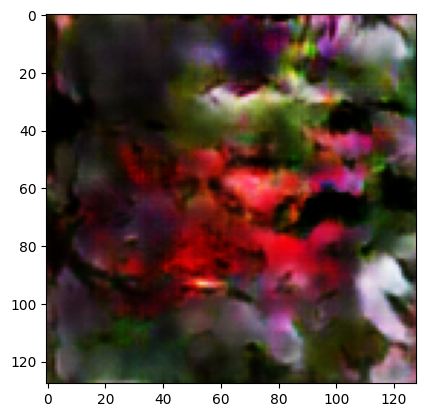

Epoch [350/500] loss_D: 0.6147 loss_G: 3.6684 time: 27.97
Epoch [351/500] loss_D: 0.4086 loss_G: 3.0635 time: 28.53
Epoch [352/500] loss_D: 0.6992 loss_G: 3.4644 time: 28.42
Epoch [353/500] loss_D: 0.4178 loss_G: 3.2596 time: 28.61
Epoch [354/500] loss_D: 0.6005 loss_G: 3.5684 time: 28.65
Epoch [355/500] loss_D: 0.5199 loss_G: 3.5082 time: 28.60
Epoch [356/500] loss_D: 0.5019 loss_G: 3.4321 time: 28.55
Epoch [357/500] loss_D: 0.5910 loss_G: 3.7093 time: 28.85
Epoch [358/500] loss_D: 0.5382 loss_G: 3.6482 time: 28.21
Epoch [359/500] loss_D: 0.4081 loss_G: 3.2087 time: 28.53
Epoch [360/500] loss_D: 0.4959 loss_G: 3.6450 time: 29.50
Epoch [361/500] loss_D: 0.6674 loss_G: 3.6501 time: 27.95
Epoch [362/500] loss_D: 0.8950 loss_G: 4.1330 time: 27.77
Epoch [363/500] loss_D: 0.5381 loss_G: 3.2870 time: 37.04
Epoch [364/500] loss_D: 0.6862 loss_G: 3.4721 time: 42.95
Epoch [365/500] loss_D: 0.6106 loss_G: 3.4071 time: 42.78
Epoch [366/500] loss_D: 0.6388 loss_G: 3.3868 time: 43.45
Epoch [367/500

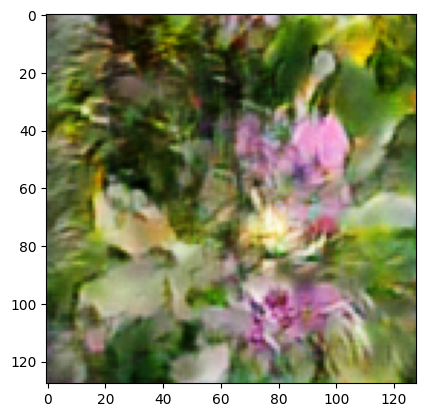

Epoch [400/500] loss_D: 0.4191 loss_G: 2.9128 time: 28.09
Epoch [401/500] loss_D: 0.6139 loss_G: 3.2680 time: 27.76
Epoch [402/500] loss_D: 0.6388 loss_G: 4.0167 time: 41.31
Epoch [403/500] loss_D: 0.5211 loss_G: 3.9895 time: 43.01
Epoch [404/500] loss_D: 0.6038 loss_G: 3.9749 time: 42.64
Epoch [405/500] loss_D: 0.8116 loss_G: 4.1854 time: 42.38
Epoch [406/500] loss_D: 0.7260 loss_G: 3.8603 time: 42.74
Epoch [407/500] loss_D: 0.3670 loss_G: 3.3804 time: 42.45
Epoch [408/500] loss_D: 0.6518 loss_G: 3.7293 time: 42.96
Epoch [409/500] loss_D: 0.5475 loss_G: 3.4359 time: 42.48
Epoch [410/500] loss_D: 0.5121 loss_G: 3.3492 time: 42.87
Epoch [411/500] loss_D: 0.5026 loss_G: 3.8675 time: 42.95
Epoch [412/500] loss_D: 0.4853 loss_G: 3.3553 time: 42.51
Epoch [413/500] loss_D: 0.6599 loss_G: 3.3682 time: 42.61
Epoch [414/500] loss_D: 0.8184 loss_G: 4.4340 time: 42.86
Epoch [415/500] loss_D: 0.5434 loss_G: 3.4414 time: 43.21
Epoch [416/500] loss_D: 0.3372 loss_G: 3.1171 time: 48.24
Epoch [417/500

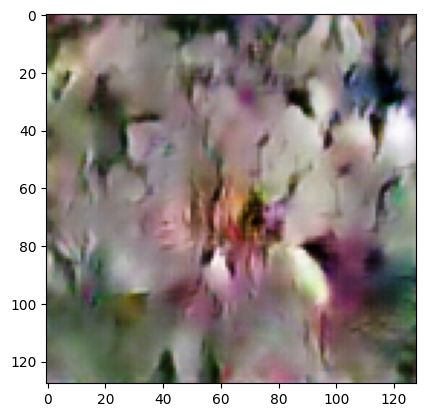

Epoch [450/500] loss_D: 1.3481 loss_G: 3.8859 time: 41.21
Epoch [451/500] loss_D: 0.4263 loss_G: 3.4924 time: 40.86
Epoch [452/500] loss_D: 0.5125 loss_G: 4.1303 time: 41.13
Epoch [453/500] loss_D: 0.4213 loss_G: 3.6253 time: 41.12
Epoch [454/500] loss_D: 0.4441 loss_G: 3.7078 time: 42.50
Epoch [455/500] loss_D: 0.3398 loss_G: 3.0309 time: 42.87
Epoch [456/500] loss_D: 0.3216 loss_G: 3.5218 time: 40.20
Epoch [457/500] loss_D: 0.4002 loss_G: 3.8869 time: 27.38
Epoch [458/500] loss_D: 0.6912 loss_G: 4.3302 time: 34.44
Epoch [459/500] loss_D: 0.3329 loss_G: 3.6283 time: 34.10
Epoch [460/500] loss_D: 0.6730 loss_G: 4.0416 time: 28.09
Epoch [461/500] loss_D: 0.3553 loss_G: 3.9762 time: 27.87
Epoch [462/500] loss_D: 0.5371 loss_G: 4.0553 time: 28.21
Epoch [463/500] loss_D: 0.4866 loss_G: 4.3122 time: 27.12
Epoch [464/500] loss_D: 0.4164 loss_G: 3.7678 time: 31.01
Epoch [465/500] loss_D: 0.3160 loss_G: 3.5875 time: 43.21
Epoch [466/500] loss_D: 0.2826 loss_G: 3.2850 time: 43.03
Epoch [467/500

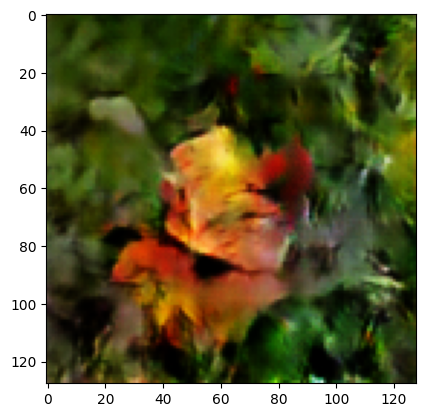

Epoch [500/500] loss_D: 0.7448 loss_G: 5.5730 time: 43.08


In [15]:
import time

epochs = 500

for epoch in range(epochs):

    d_losses, g_losses = [], []

    epoch_time = time.time()

    for batch in dataloader:
        images = batch["image"].to(device)
        embed_captions = batch["embed_caption"].to(device)

        # labels
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        # Training discriminator
        optimizer_D.zero_grad()

        noise = torch.rand((images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)

        with torch.autocast(device_type="cuda", dtype=torch.bfloat16, cache_enabled=True, enabled=True):
            real_loss = bce_loss(
                discriminator(images, embed_captions),
                real_labels
            )

            fake_loss = bce_loss(
                discriminator(fake_images.detach(), embed_captions),
                fake_labels
            )

            d_loss = real_loss + fake_loss

        d_loss.backward()

        optimizer_D.step()

        d_losses.append(d_loss.item())

        # Training Generator
        optimizer_G.zero_grad()

        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)
        
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16, cache_enabled=True, enabled=True):
            g_loss = bce_loss(
                discriminator(fake_images, embed_captions),
                real_labels # Fooling Discriminator here
            )

        g_loss.backward()

        optimizer_G.step()

        g_losses.append(g_loss.item())


    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)

    if (epoch + 1) % 50 == 0:
        plot_output(generator)

    print(
        "Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}".format(
            epoch + 1, epochs, avg_d_loss, avg_g_loss, time.time() - epoch_time
        )
    )

In [18]:
import torch

# Save generator
torch.save(generator.state_dict(), 'generator_contrastive.pth')

# Save discriminator
torch.save(discriminator.state_dict(), 'discriminator_contrastive.pth')

In [42]:
ds[5]['text']

'this flower is white and purple in color, with petals that are oval shaped.'

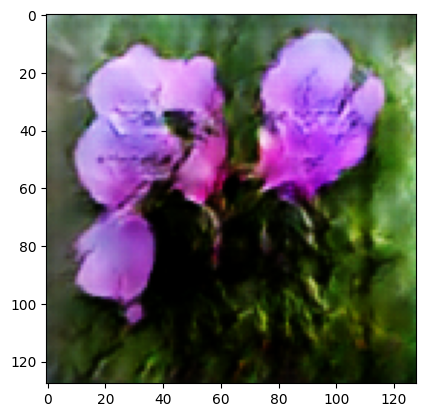

In [61]:
generator.eval()

noise = torch.randn(size=(1, 100))
text_embedding = ds[5]['embed_caption'].unsqueeze(0)
with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))
grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
show_grid(grid)